Load libraries

In [1]:
library(here);
library(Distance); # for summarize_ds_models function
library(dsm) # for dsm_cor function
library(mrds)
library(mgcv); # for gam function   
library(dplyr)      # For data manipulation
library(ggplot2)
library(RColorBrewer);

here() starts at C:/Users/lhambrec/Sync/1_Projects/Simulator/DroneSurveySimulator

Loading required package: mrds

This is mrds 2.3.0
Built: R 4.4.1; ; 2024-09-23 01:27:36 UTC; windows

**Change to default variance estimator for point transects. The default encounter rate variance estimator for point transects is now 'P2' (changed from 'P3'). See 'Uncertainty' section of ?dht for more information.**

MCDS.exe not detected, single observer analyses will only be run using optimiser in mrds R library. See ?MCDS for details.


Attaching package: 'Distance'


The following object is masked from 'package:mrds':

    create.bins


Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Loading required package: numDeriv

Registered S3 methods overwritten by 'dsm':
  method                 from    
  predict.fake_ddf       Distance
  print.fake_ddf         Distance
  print.summary.fake_ddf Distance
  summary.fake_ddf       

Load data

In [2]:
# Set default figure size and resolution
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)

# Define a colour palette
colour_palette <- brewer.pal(5, "RdBu")

# define list with WUM numbers
wmu_number_list <- c('501','503', '512', '517', '528')
wmu_number <- wmu_number_list[4]
# loop through WUM numbers
# for(wmu_number in wmu_number_list){

  # Load processed data
  input_path <- here("Output", "DSM", paste0("dsm",wmu_number,".RData"))
  load(file = input_path)

  # Assign individal names to data frames
  # assign(paste0("dsm_list_",wmu_number), dsm_list)
  # assign(paste0("detfc_list_bin_compact",wmu_number), detfc_list_bin_compact)
  # rm(dsm_list, detfc_list_bin_compact)
# }

remove_invalid_models <- function(model_list) {
  valid_models <- list()
  
  for (i in seq_along(model_list)) {
    model <- model_list[[i]]
    model_name <- names(model_list)[i]
    tryCatch({
      # Attempt to get the summary of the model
      model_summary <- summary(model)
      # If successful, add the model to the valid_models list with its name
      valid_models[[model_name]] <- model
    }, error = function(e) {
      # If an error occurs, print a message and skip the model
      message(sprintf("Model '%s' at index %d is invalid and will be removed: %s", model_name, i, e$message))
    })
  }
  
  return(valid_models)
}

# Use the function to filter the models
detfc_list_bin_compact <- remove_invalid_models(detfc_list_bin_compact)

Error in solve.default(m) : 
  system is computationally singular: reciprocal condition number = 2.4456e-19


Warning message in diag(vcov):
"NAs introduced by coercion"
Model 'detfc_cc_hn_null_trunc_0.6_bin_0.05' at index 5 is invalid and will be removed: invalid 'nrow' value (too large or NA)



Error in solve.default(m) : 
  system is computationally singular: reciprocal condition number = 1.75626e-17


Warning message in diag(vcov):
"NAs introduced by coercion"
Model 'detfc_cc_hn_null_trunc_0.55_bin_0.05' at index 10 is invalid and will be removed: invalid 'nrow' value (too large or NA)



Rank models

In [3]:
aic_values_bin <- purrr::map_dbl(detfc_list_bin_compact, ~ .x$ddf$criterion)
# Extract CV values for each model
cv_values_bin <- purrr::map_dbl(detfc_list_bin_compact, function(model) {
  model_summary <- summary(model)
  cv_value <- model_summary$ds$Nhat.se[1] / model_summary$ds$Nhat
  return(cv_value)
})

# Extract Chi-Square values for each model
chi_square_values_bin <- purrr::map_dbl(detfc_list_bin_compact, function(model) {
  gof_test <- ddf.gof(model$ddf)
  chi_square_value <- gof_test$chisquare$chi1$chisq
  return(chi_square_value)
})

# Combine AIC and CV values into a dataframe
model_metrics <- data.frame(
  Model = names(detfc_list_bin_compact),
  AIC = round(aic_values_bin,0),
  CV = round(cv_values_bin,3),
  Chi_Square = round(chi_square_values_bin,1)
)

# Normalise AIC and CV (assuming lower values are better)
model_metrics <- model_metrics %>%
  mutate(
    AIC_normalised = (AIC - min(AIC)) / (max(AIC) - min(AIC)),
    CV_normalised = (CV - min(CV)) / (max(CV) - min(CV)),
    Chi_Square_normalised = (Chi_Square - min(Chi_Square)) / (max(Chi_Square) - min(Chi_Square))
  )

# Define weights for AIC, CV and Chi-Square (adjust these weights according to your preference)
weight_AIC <- 1
weight_CV <- 0.5
weight_Chi_Square <- 0.5

# Combine the normalized values using the weights
model_metrics <- model_metrics %>%
  mutate(
    combined_score = weight_AIC * AIC_normalised + weight_CV * CV_normalised + weight_Chi_Square * Chi_Square_normalised
  ) %>%
  arrange(combined_score)

row.names(model_metrics) <- NULL;

In [4]:
knitr::kable(model_metrics, digits = 3, escape = FALSE, caption = "Model comparison metrics") # %>%
  # kable_styling(full_width = FALSE, position = "center")



Table: Model comparison metrics

|Model                                | AIC|        CV| Chi_Square| AIC_normalised| CV_normalised| Chi_Square_normalised| combined_score|
|:------------------------------------|---:|---------:|----------:|--------------:|-------------:|---------------------:|--------------:|
|detfc_hr_null_trunc_0.55_bin_0.05    | 656|     0.663|       24.9|          0.000|             0|                 0.000|          0.000|
|detfc_hr_null_trunc_0.6_bin_0.05     | 671|     0.685|       27.4|          0.170|             0|                 0.026|          0.183|
|detfc_hn_cos_trunc_0.55_bin_0.05     | 699|     0.095|       64.0|          0.489|             0|                 0.401|          0.689|
|detfc_hn_cos_trunc_0.6_bin_0.05      | 715|     0.085|       73.0|          0.670|             0|                 0.494|          0.917|
|detfc_cc_hr_null_trunc_0.55_bin_0.05 | 694| 15853.882|       26.8|          0.432|             1|                 0.020|          0.941|

In [5]:
# Select items containing 'trunc_0.6'
detfc_list_trunc_0.6 <- grep("trunc_0.6", detfc_list_bin_compact)

# Select items not containing 'trunc_0.6'
detfc_list_trunc_99 <- grep("trunc_0.6", detfc_list_bin_compact, invert = TRUE)

# for (wmu_number in wmu_number_list){
  table_ds_models_trunc_0.6 <- do.call(summarize_ds_models, detfc_list_bin_compact[detfc_list_trunc_0.6])
  table_ds_models_trunc_99 <- do.call(summarize_ds_models, detfc_list_bin_compact[detfc_list_trunc_99])


In [6]:
  knitr::kable(table_ds_models_trunc_0.6[, -1], digits=3, escape=FALSE,
             caption="Model selection summary of the 600m truncation models") # %>%
  # kable_styling(full_width = FALSE, position = "center")
  knitr::kable(table_ds_models_trunc_99[, -1], digits=3, escape=FALSE,
              caption="Model selection summary of the 99.5 percentile truncation models") # %>%
  # kable_styling(full_width = FALSE, position = "center")
  # }



Table: Model selection summary of the 600m truncation models

|   |Key function                                       |Formula                  | $\chi^2$ $p$-value| $\hat{P_a}$| se($\hat{P_a}$)| $\Delta$AIC|
|:--|:--------------------------------------------------|:------------------------|------------------:|-----------:|---------------:|-----------:|
|1  |Hazard-rate                                        |~1                       |              0.001|       0.080|           0.054|       0.000|
|4  |Hazard-rate                                        |~as.factor(canopy_cover) |                 NA|       0.055|         864.460|      36.356|
|3  |Half-normal with cosine adjustment term of order 2 |~1                       |              0.000|       0.312|           0.018|      44.310|
|2  |Half-normal                                        |~1                       |              0.000|       0.415|           0.018|      72.564|



Table: Model selection summary of the 99.5 percentile truncation models

|   |Key function                                          |Formula                  | $\chi^2$ $p$-value| $\hat{P_a}$| se($\hat{P_a}$)| $\Delta$AIC|
|:--|:-----------------------------------------------------|:------------------------|------------------:|-----------:|---------------:|-----------:|
|1  |Hazard-rate                                           |~1                       |              0.002|       0.090|           0.060|       0.000|
|4  |Hazard-rate                                           |~as.factor(canopy_cover) |                 NA|       0.059|         931.271|      38.014|
|3  |Half-normal with cosine adjustment terms of order 2,3 |~1                       |              0.000|       0.303|           0.021|      42.916|
|2  |Half-normal                                           |~1                       |              0.000|       0.446|           0.019|      74.709|

Plot detection functions

[1] "The best model is: detfc_hr_null_trunc_0.55_bin_0.05"


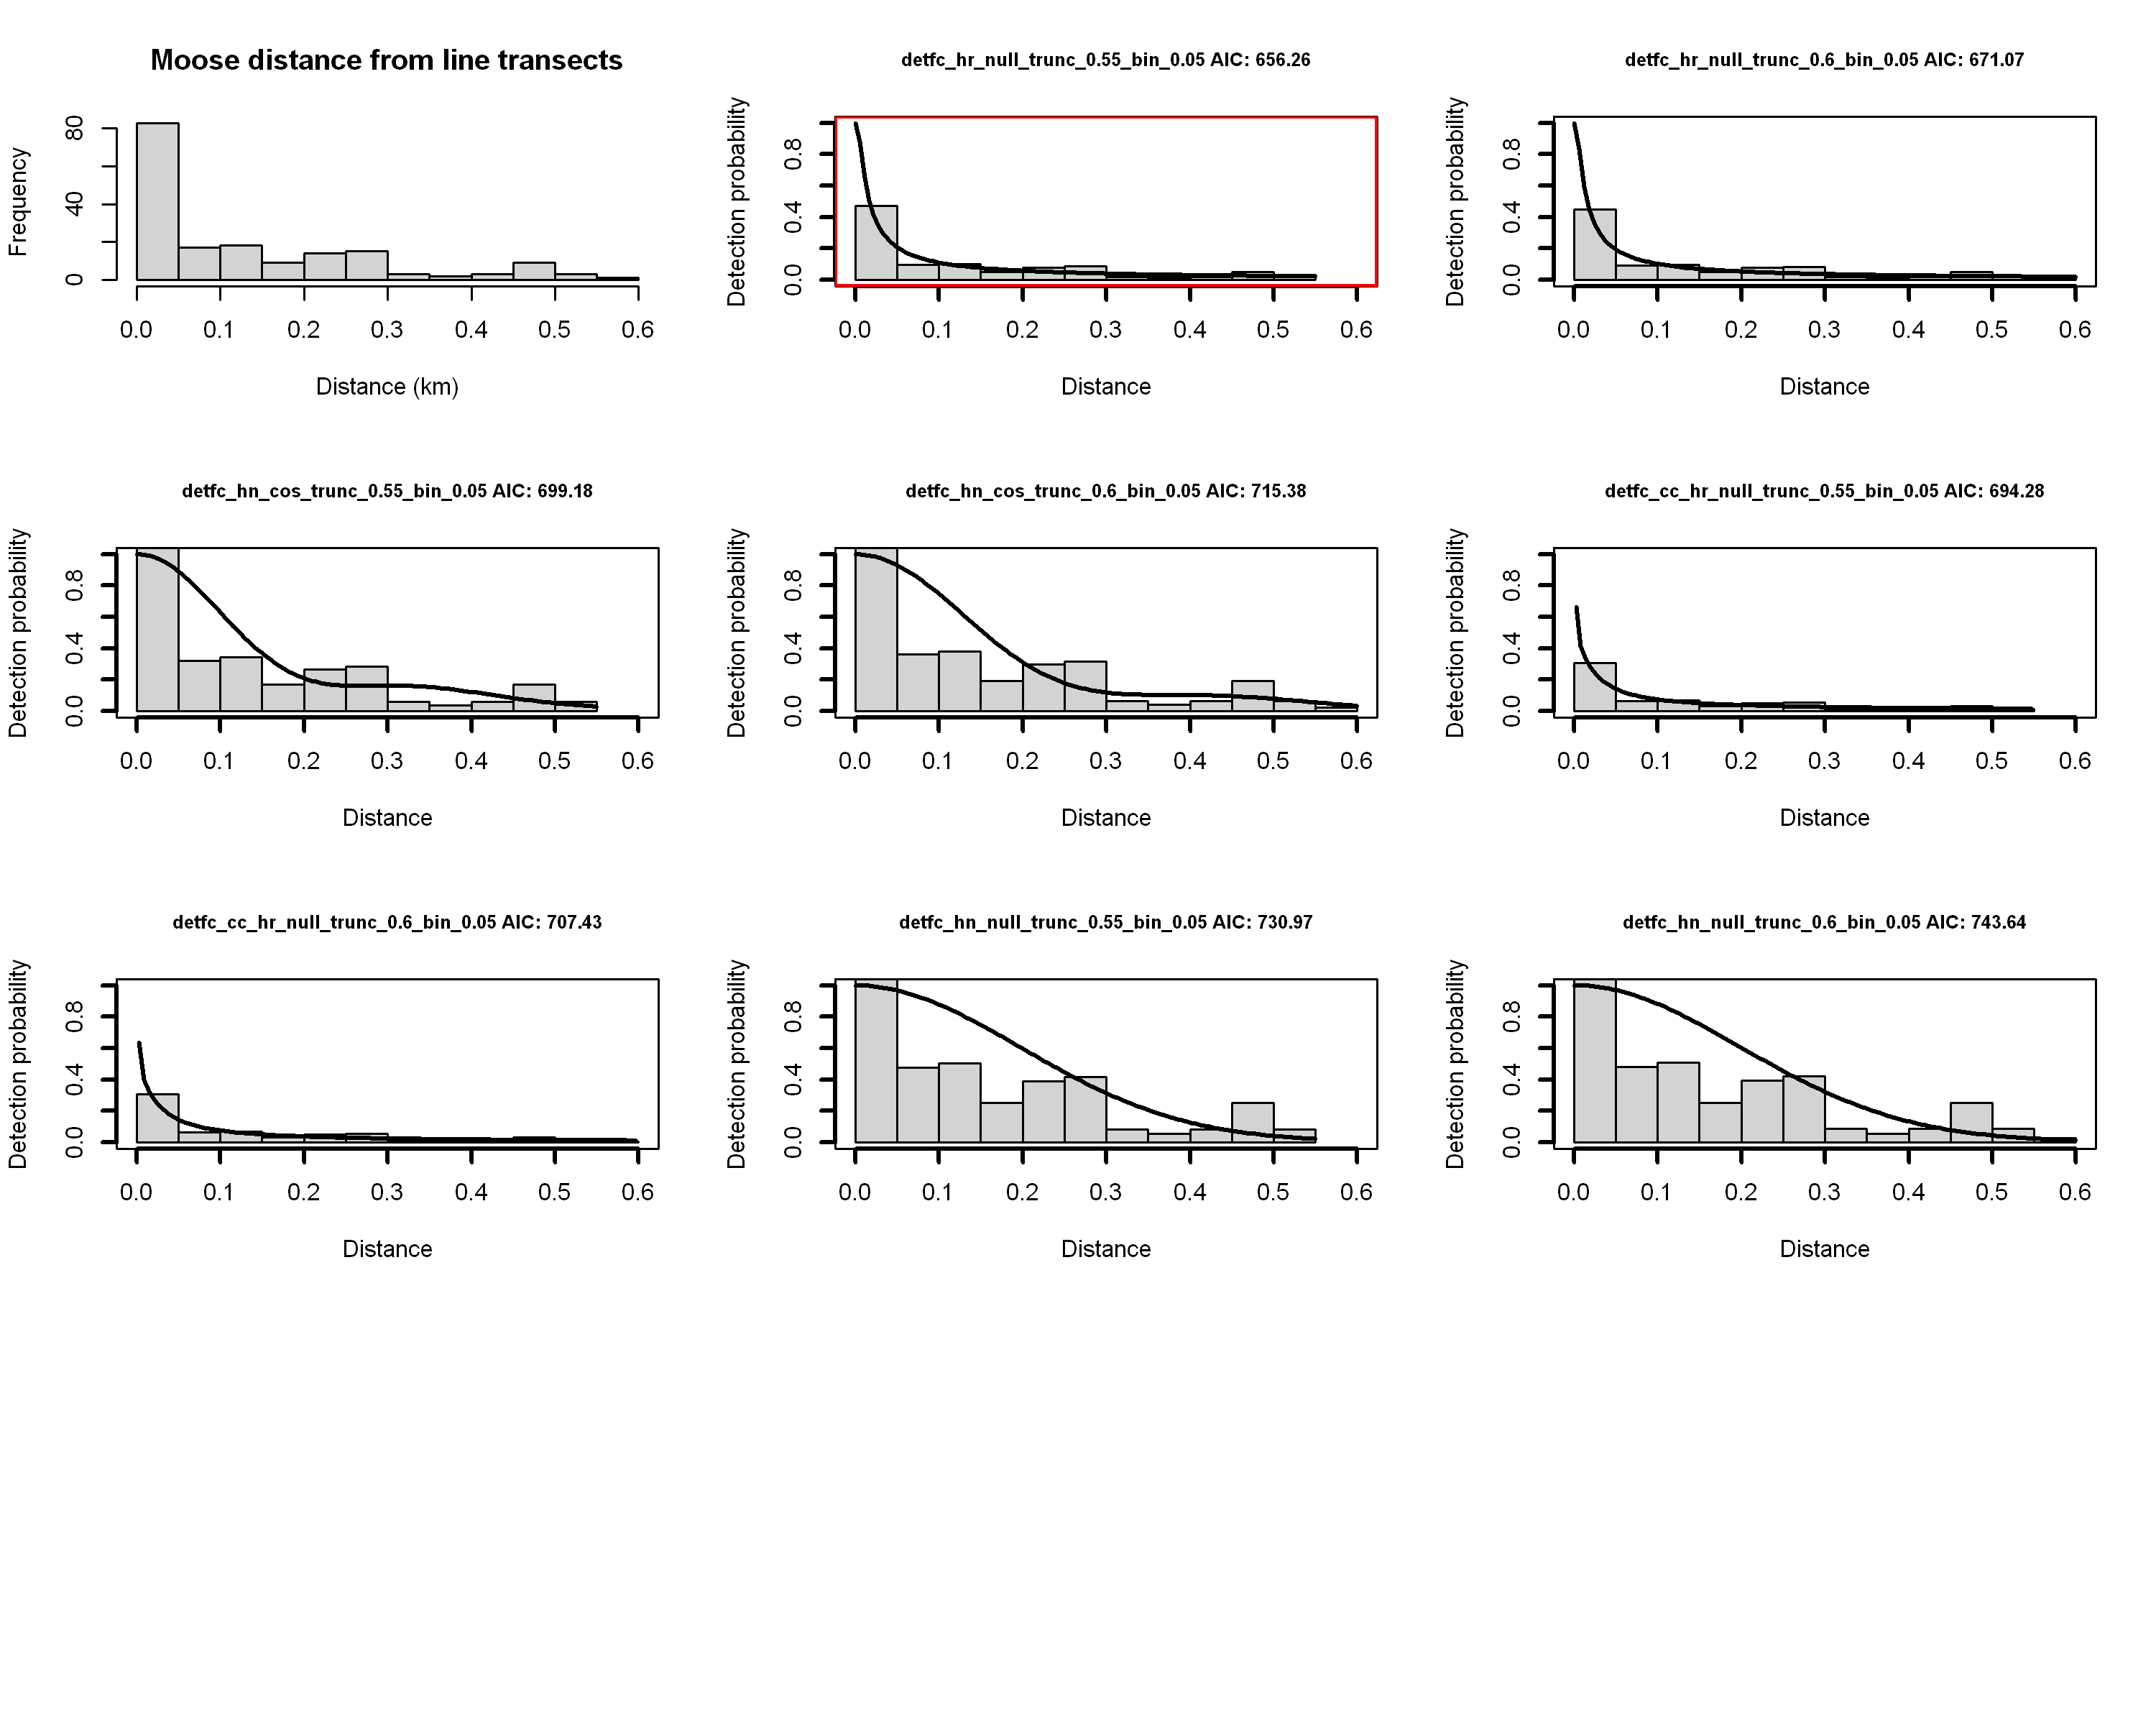

In [7]:
# select best model
best_model <- detfc_list_bin_compact[[model_metrics$Model[1]]]
print(paste0("The best model is: ", model_metrics$Model[1]))
# Plot the models
par(mfrow = c(4, 3)) # adjust based on the number of models +1
break_bins <- seq(from = 0, to = 0.6, by = 0.05)
hist(distdata$distance, main = "Moose distance from line transects", xlab = "Distance (km)", breaks = break_bins)
for (model_name in model_metrics$Model) {
  model <- detfc_list_bin_compact[[model_name]]
  # Check if the current model is the best model
  if (model_name == model_metrics$Model[1]) {
    plot(model, showpoints = FALSE, pl.den = 0, lwd =2, xlim = c(0,0.6), ylim = c(0,1), main = paste(model_name, "AIC:", round(model$ddf$criterion,2)))
    # Draw a red box around the plot
    usr <- par("usr")
    rect(usr[1], usr[3], usr[2], usr[4], border = "red", lwd = 2)
  } else {
    plot(model, showpoints = FALSE, pl.den = 0, lwd = 2, xlim = c(0,0.6), ylim = c(0,1), main = paste(model_name, "AIC:", round(model$ddf$criterion,2)))
  }
  # ddf.gof(model$ddf, qq = TRUE, main = model_name)
}
par(mfrow = c(1, 1))


plot best model

1,0,0.4715909
4,0,0.4715909
6,0,0.4715909
8,0,0.4715909
10,0,0.4715909
12,0,0.4715909
14,0,0.4715909
16,0,0.4715909
18,0,0.4715909
20,0,0.4715909
22,0,0.4715909


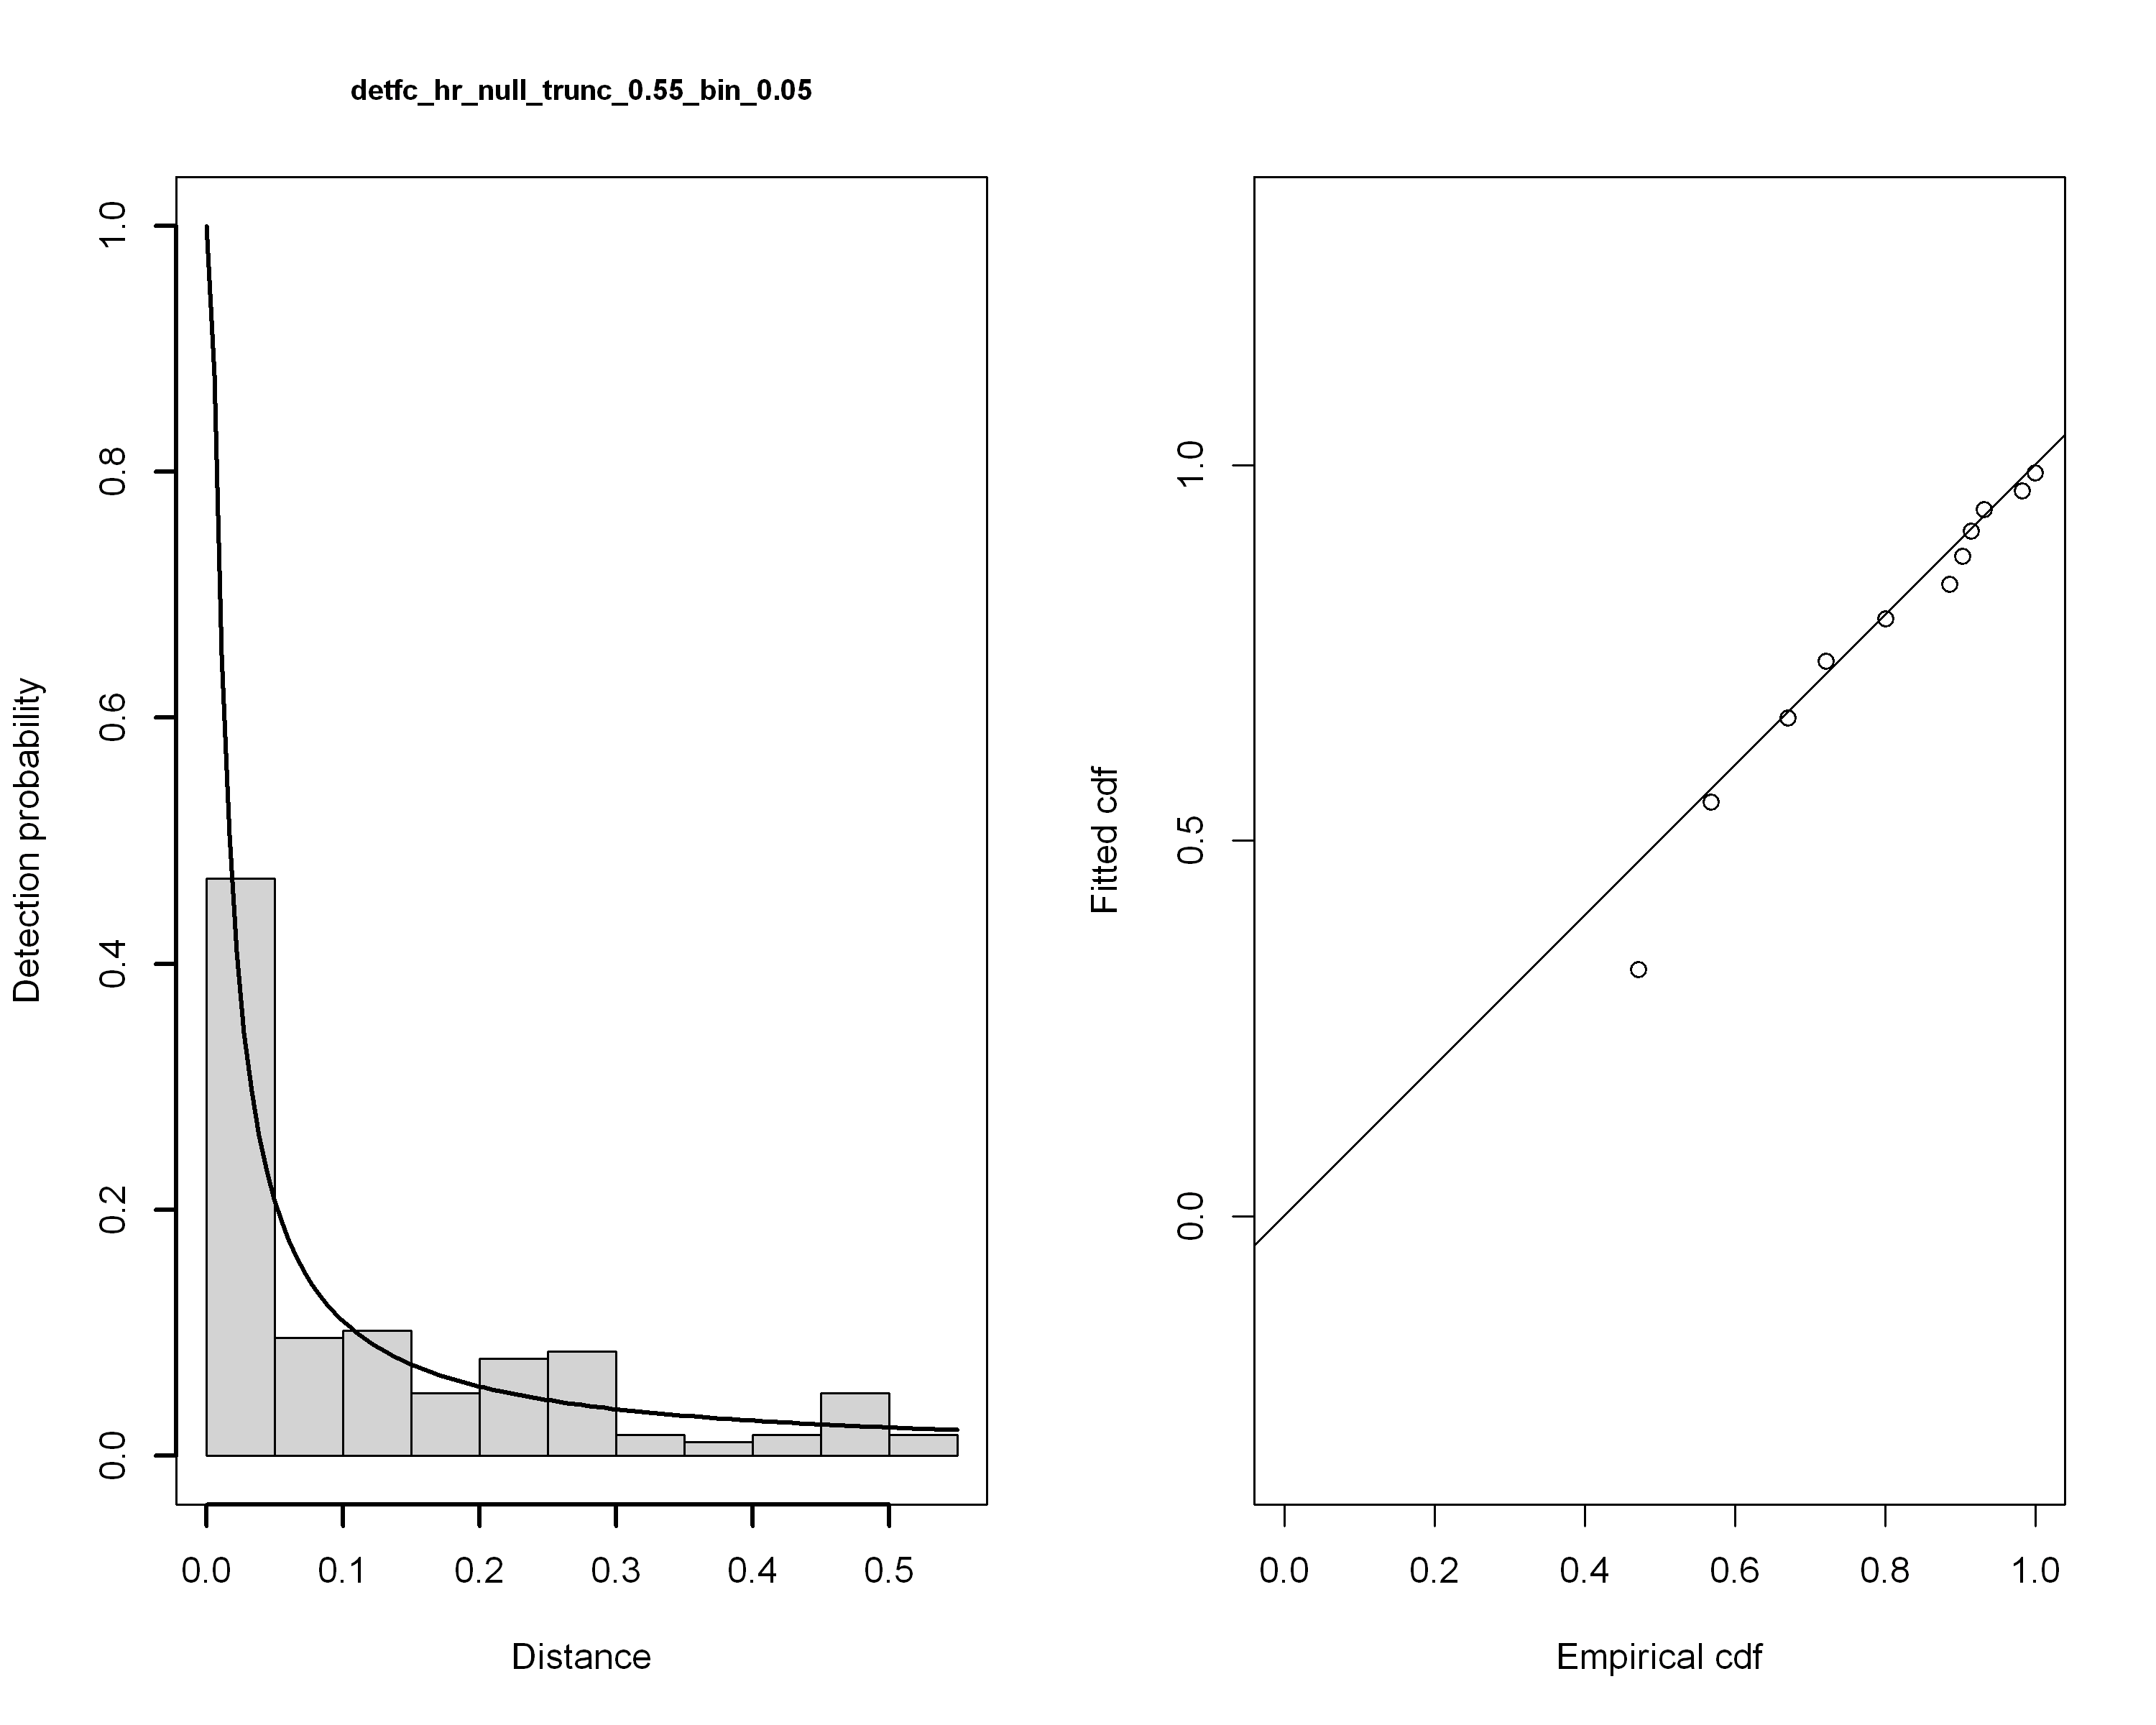

In [8]:
par(mfrow = c(1, 2))
plot(best_model, showpoints = FALSE, pl.den = 0, lwd = 2, ylim = c(0,1), main = model_metrics$Model[1])
qqplot.ddf(best_model$ddf)
par(mfrow = c(1, 1))


Plot DSM

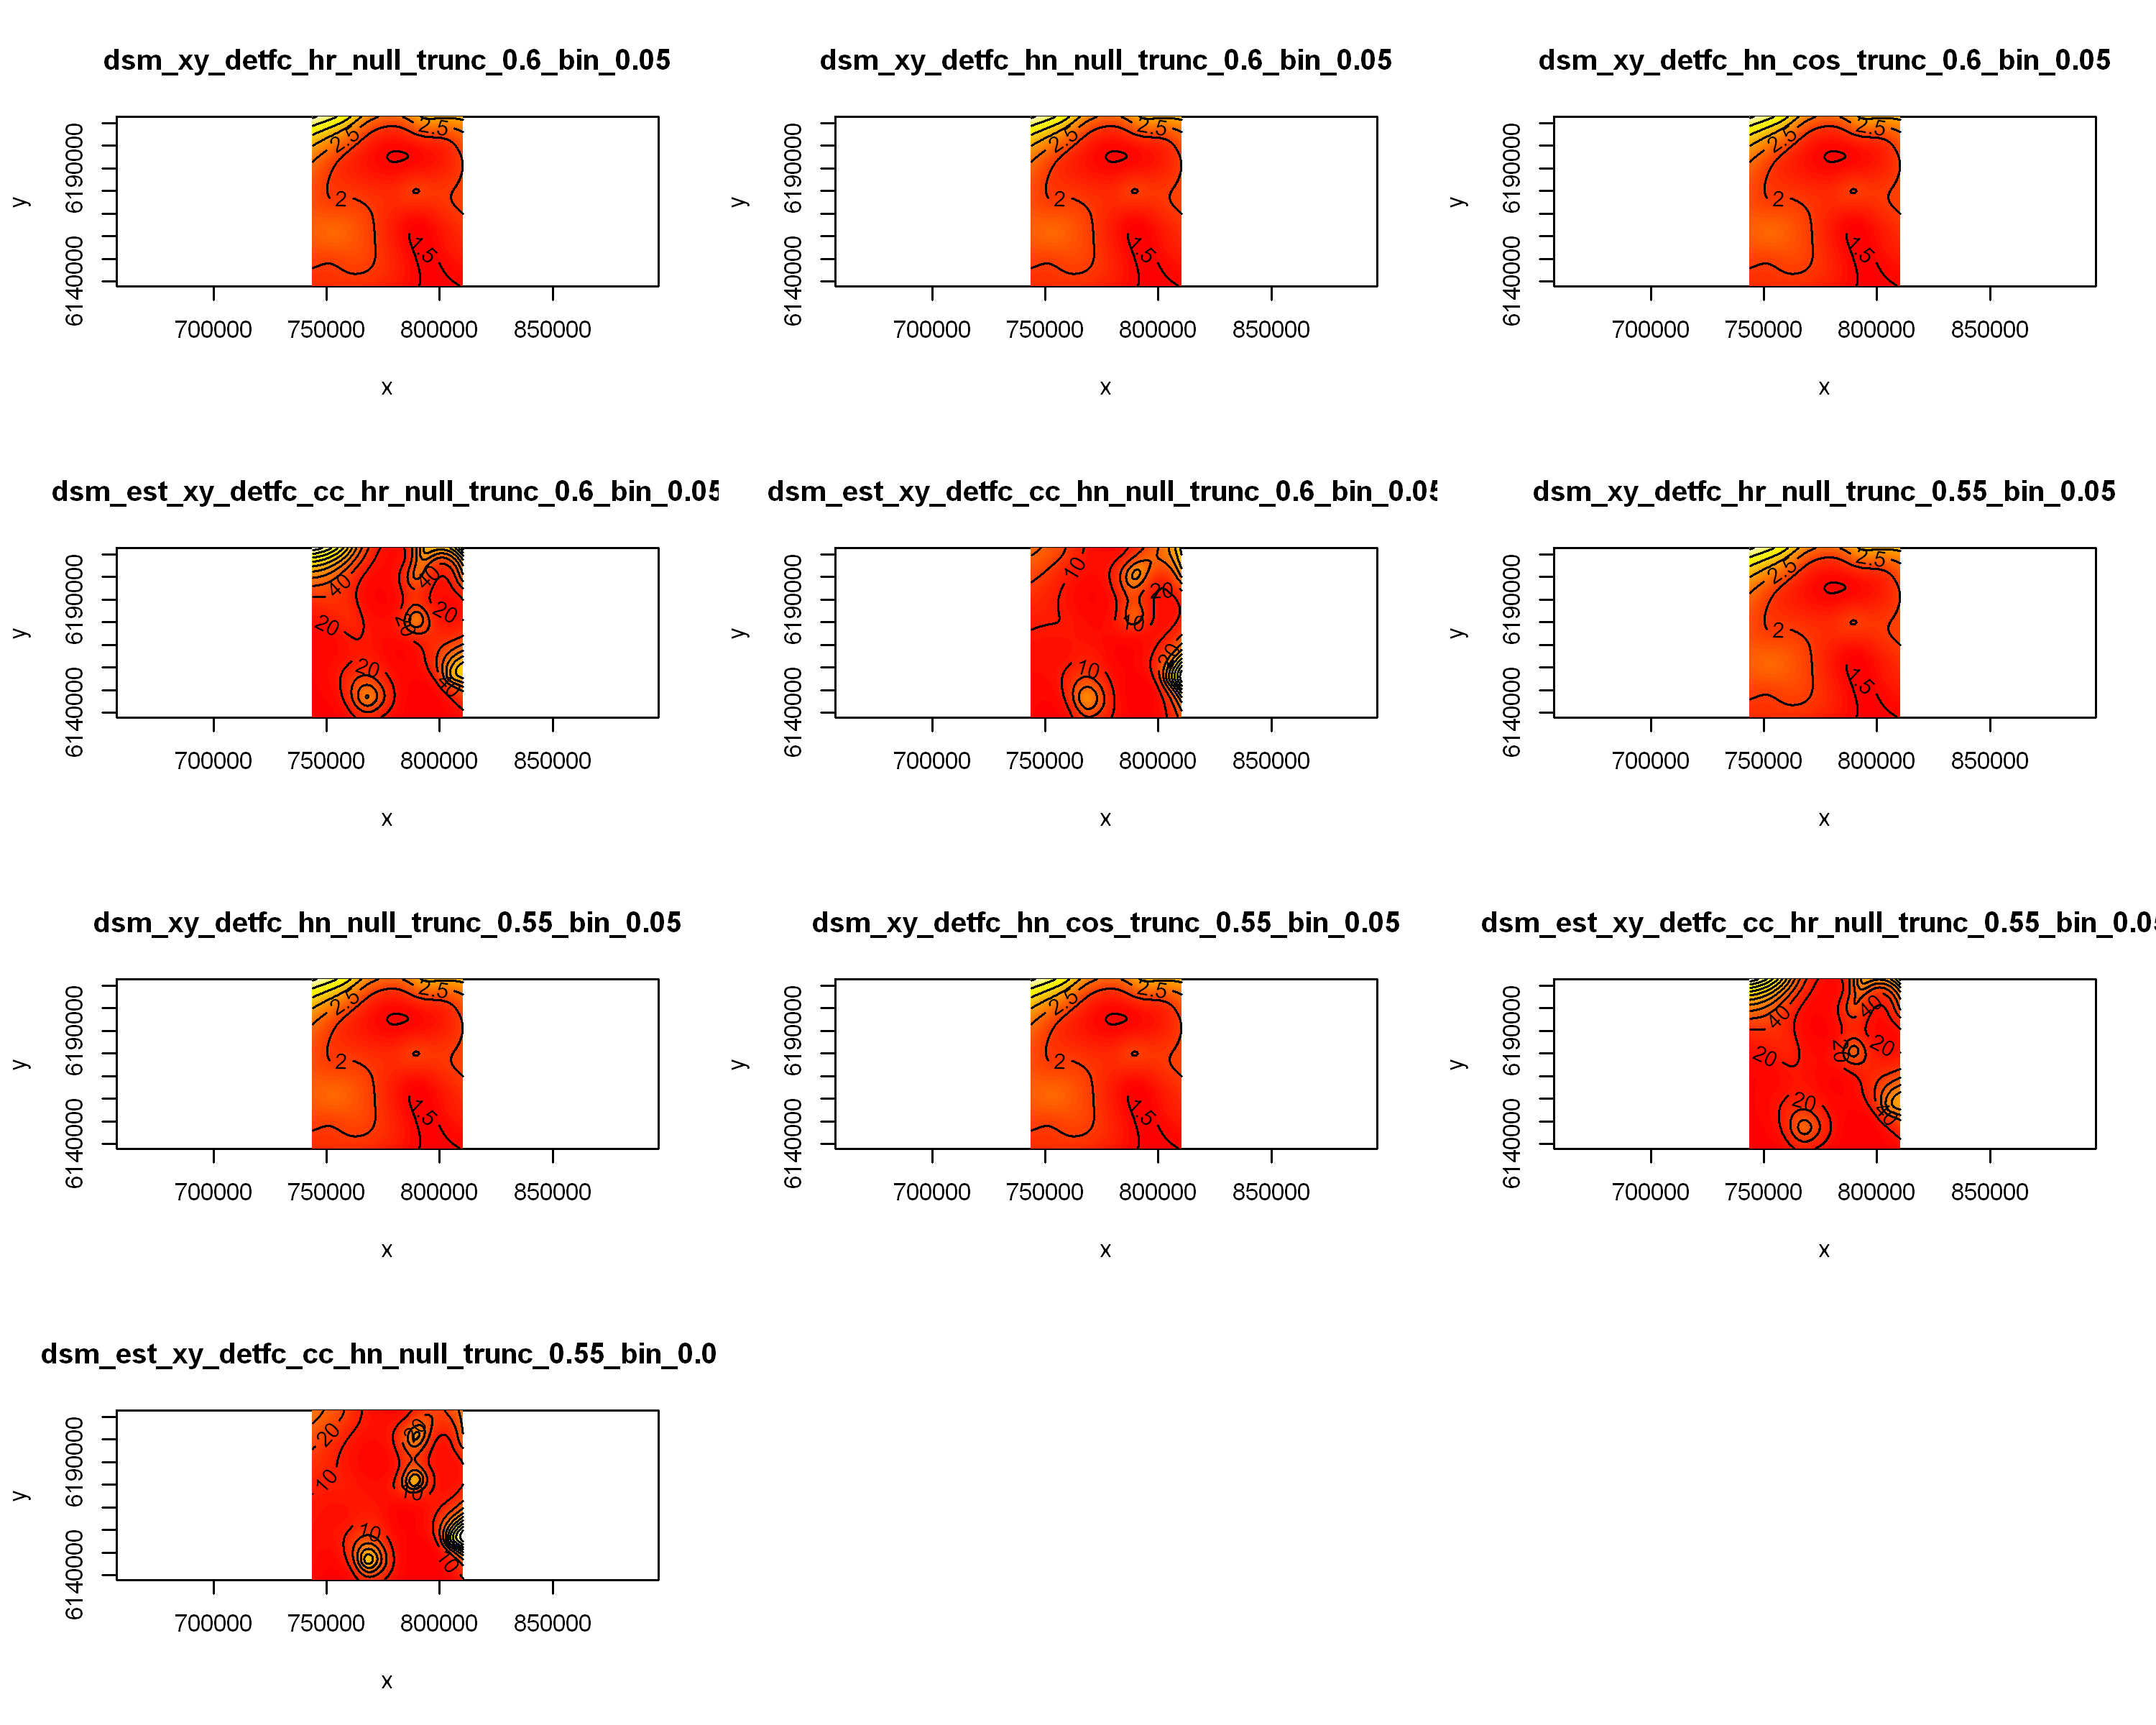

In [9]:
# Call summary and plot for each detection function after the loop
par(mfrow = c(4, 3))
for (model_name in names(dsm_list)) {
 dsm_model <- dsm_list[[model_name]]
 vis.gam(dsm_model, plot.type = "contour", view = c("x", "y"), asp = 1, type = "response", contour.col = "black", n.grid = 500, main = model_name)
}
par(mfrow = c(1, 1))

Check autocorrelation

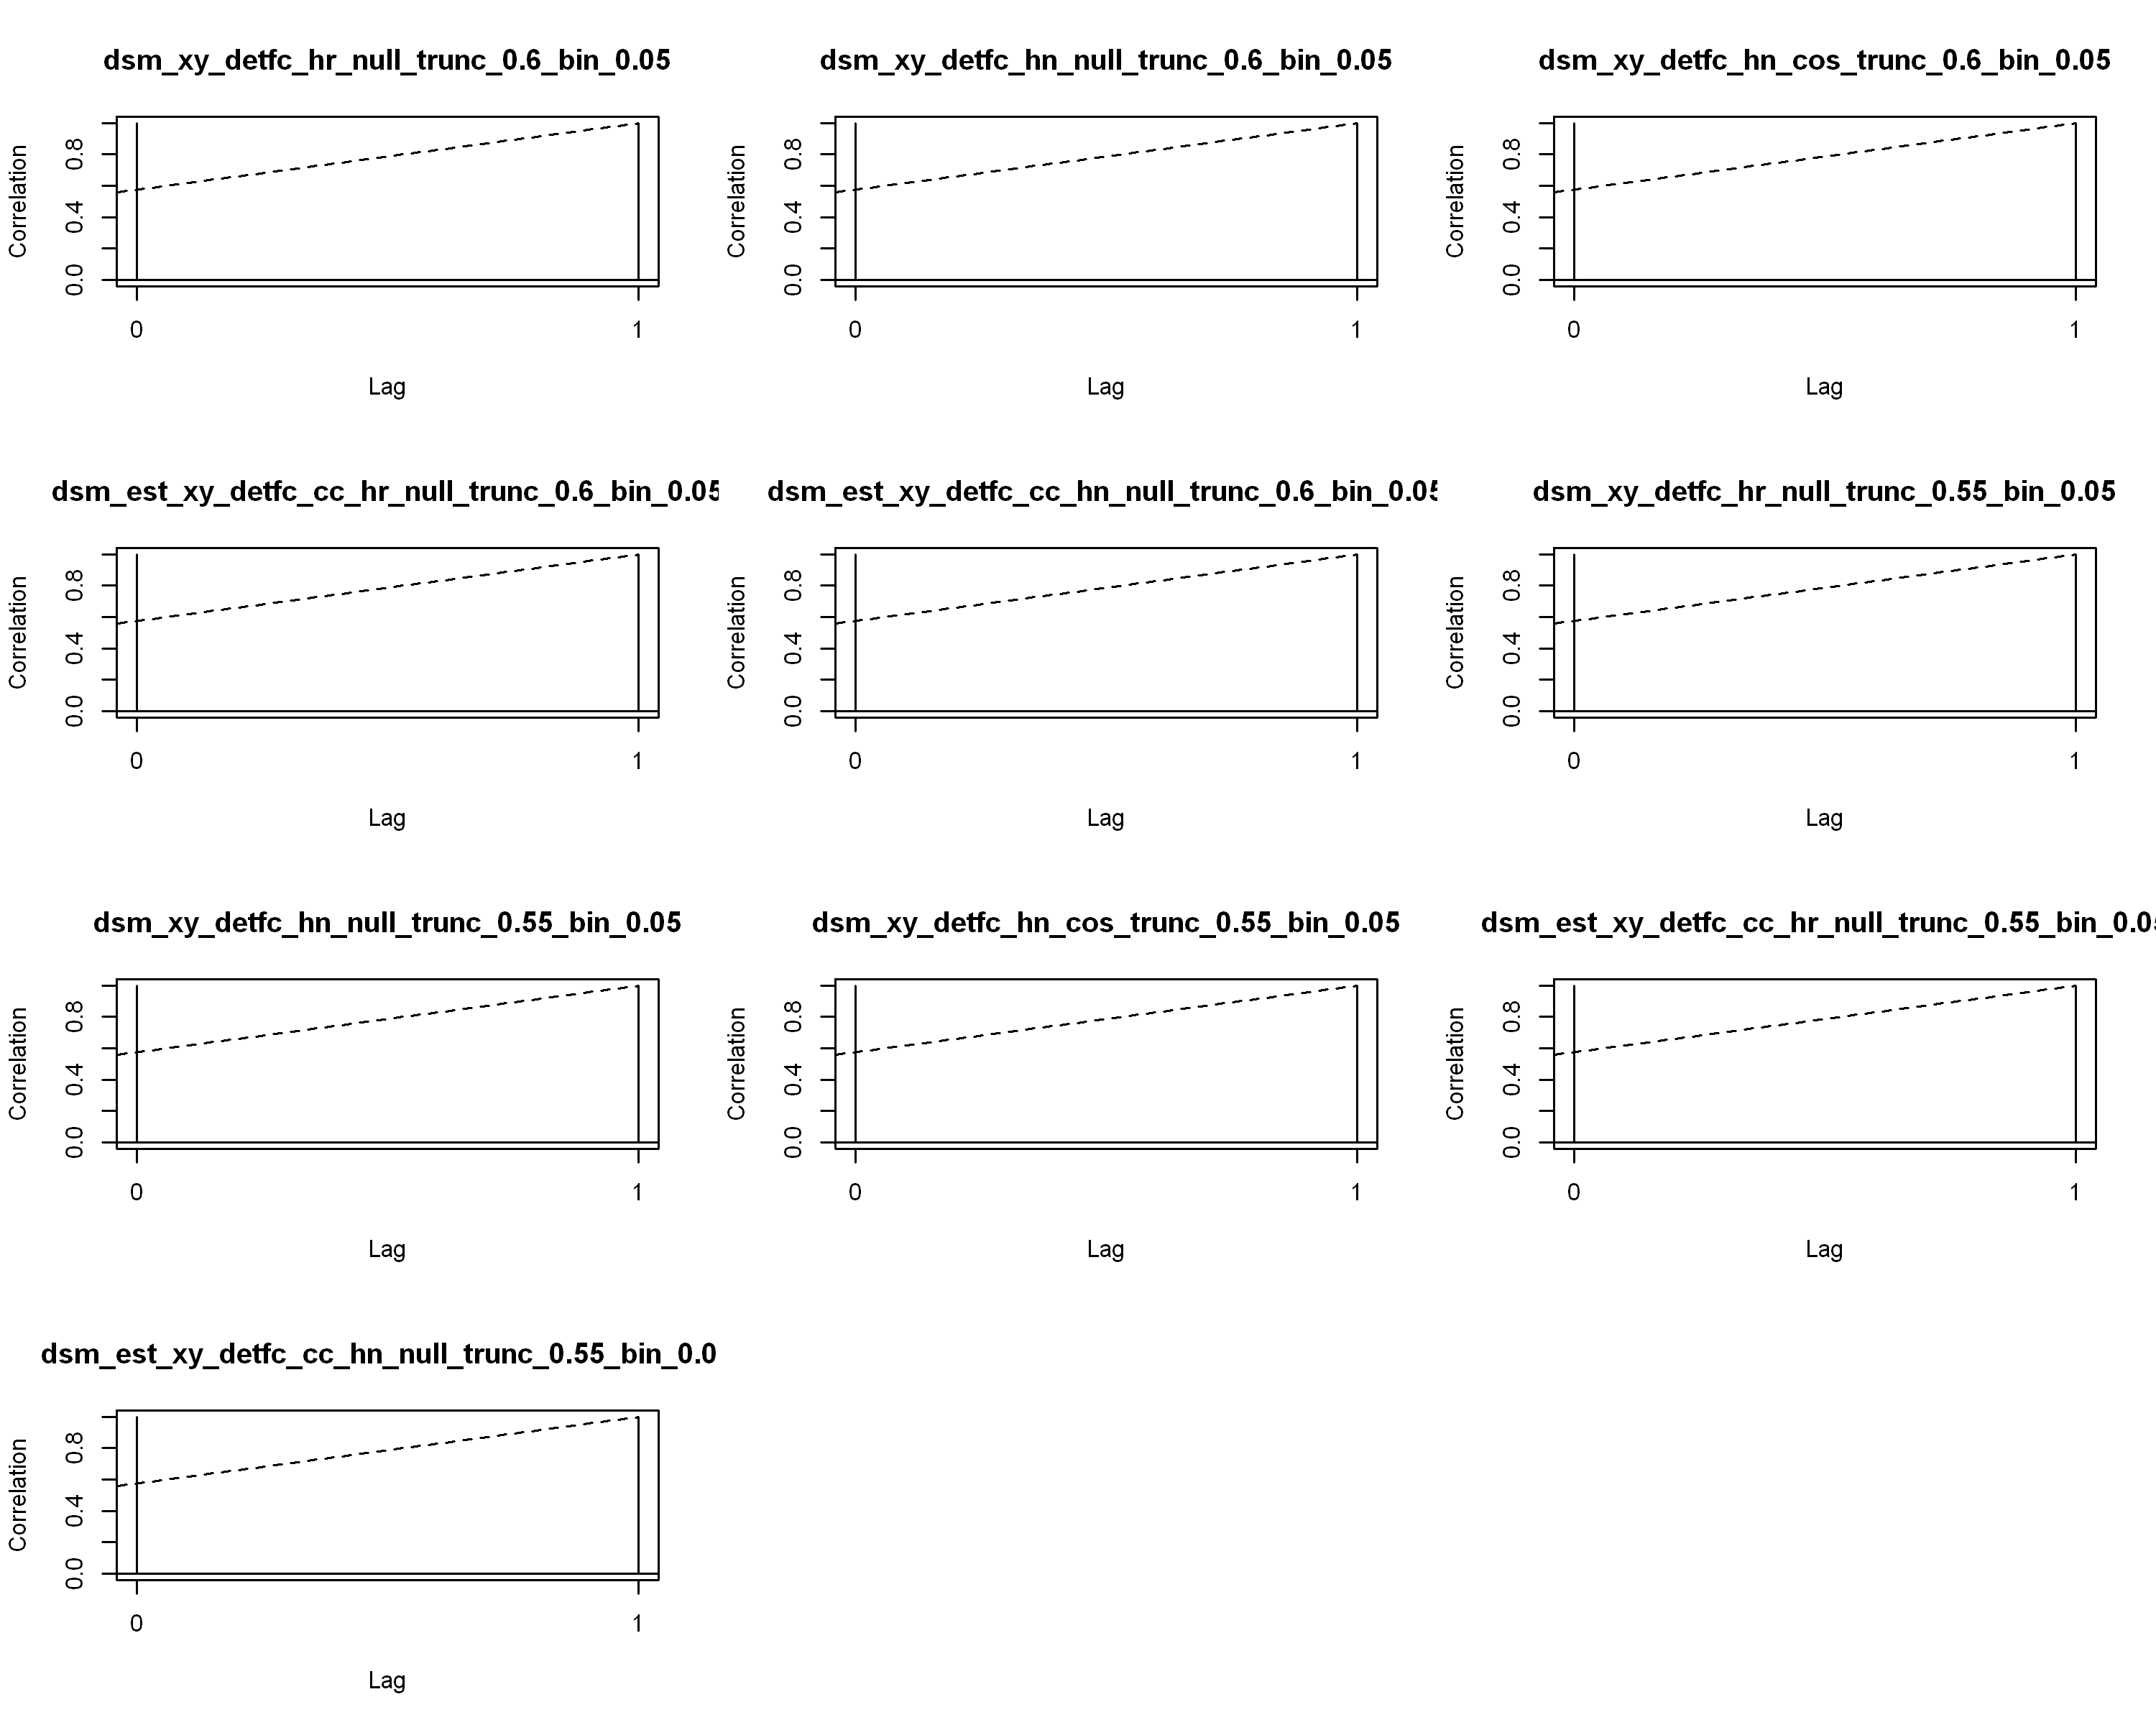

In [10]:
# Check for autocorrelation
par(mfrow = c(4, 3))
for (i in 1:length(dsm_list)) {
  dsm_cor(dsm_list[[i]], max.lag = 6, Segment.Label = "Sample.Label", main = names(dsm_list)[[i]])
}
par(mfrow = c(1, 1))

Check goodness of fit with Q-Q plots


Method: REML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-5.237695e-10,4.218137e-11]
(score -37.22621 & scale 0.1798896).
Hessian positive definite, eigenvalue range [3.033077,87.58743].
Model rank =  30 / 30 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

         k'  edf k-index p-value    
s(x,y) 29.0 16.1    0.74  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
[1] "dsm_xy_detfc_hn_null_trunc_0.55_bin_0.05"


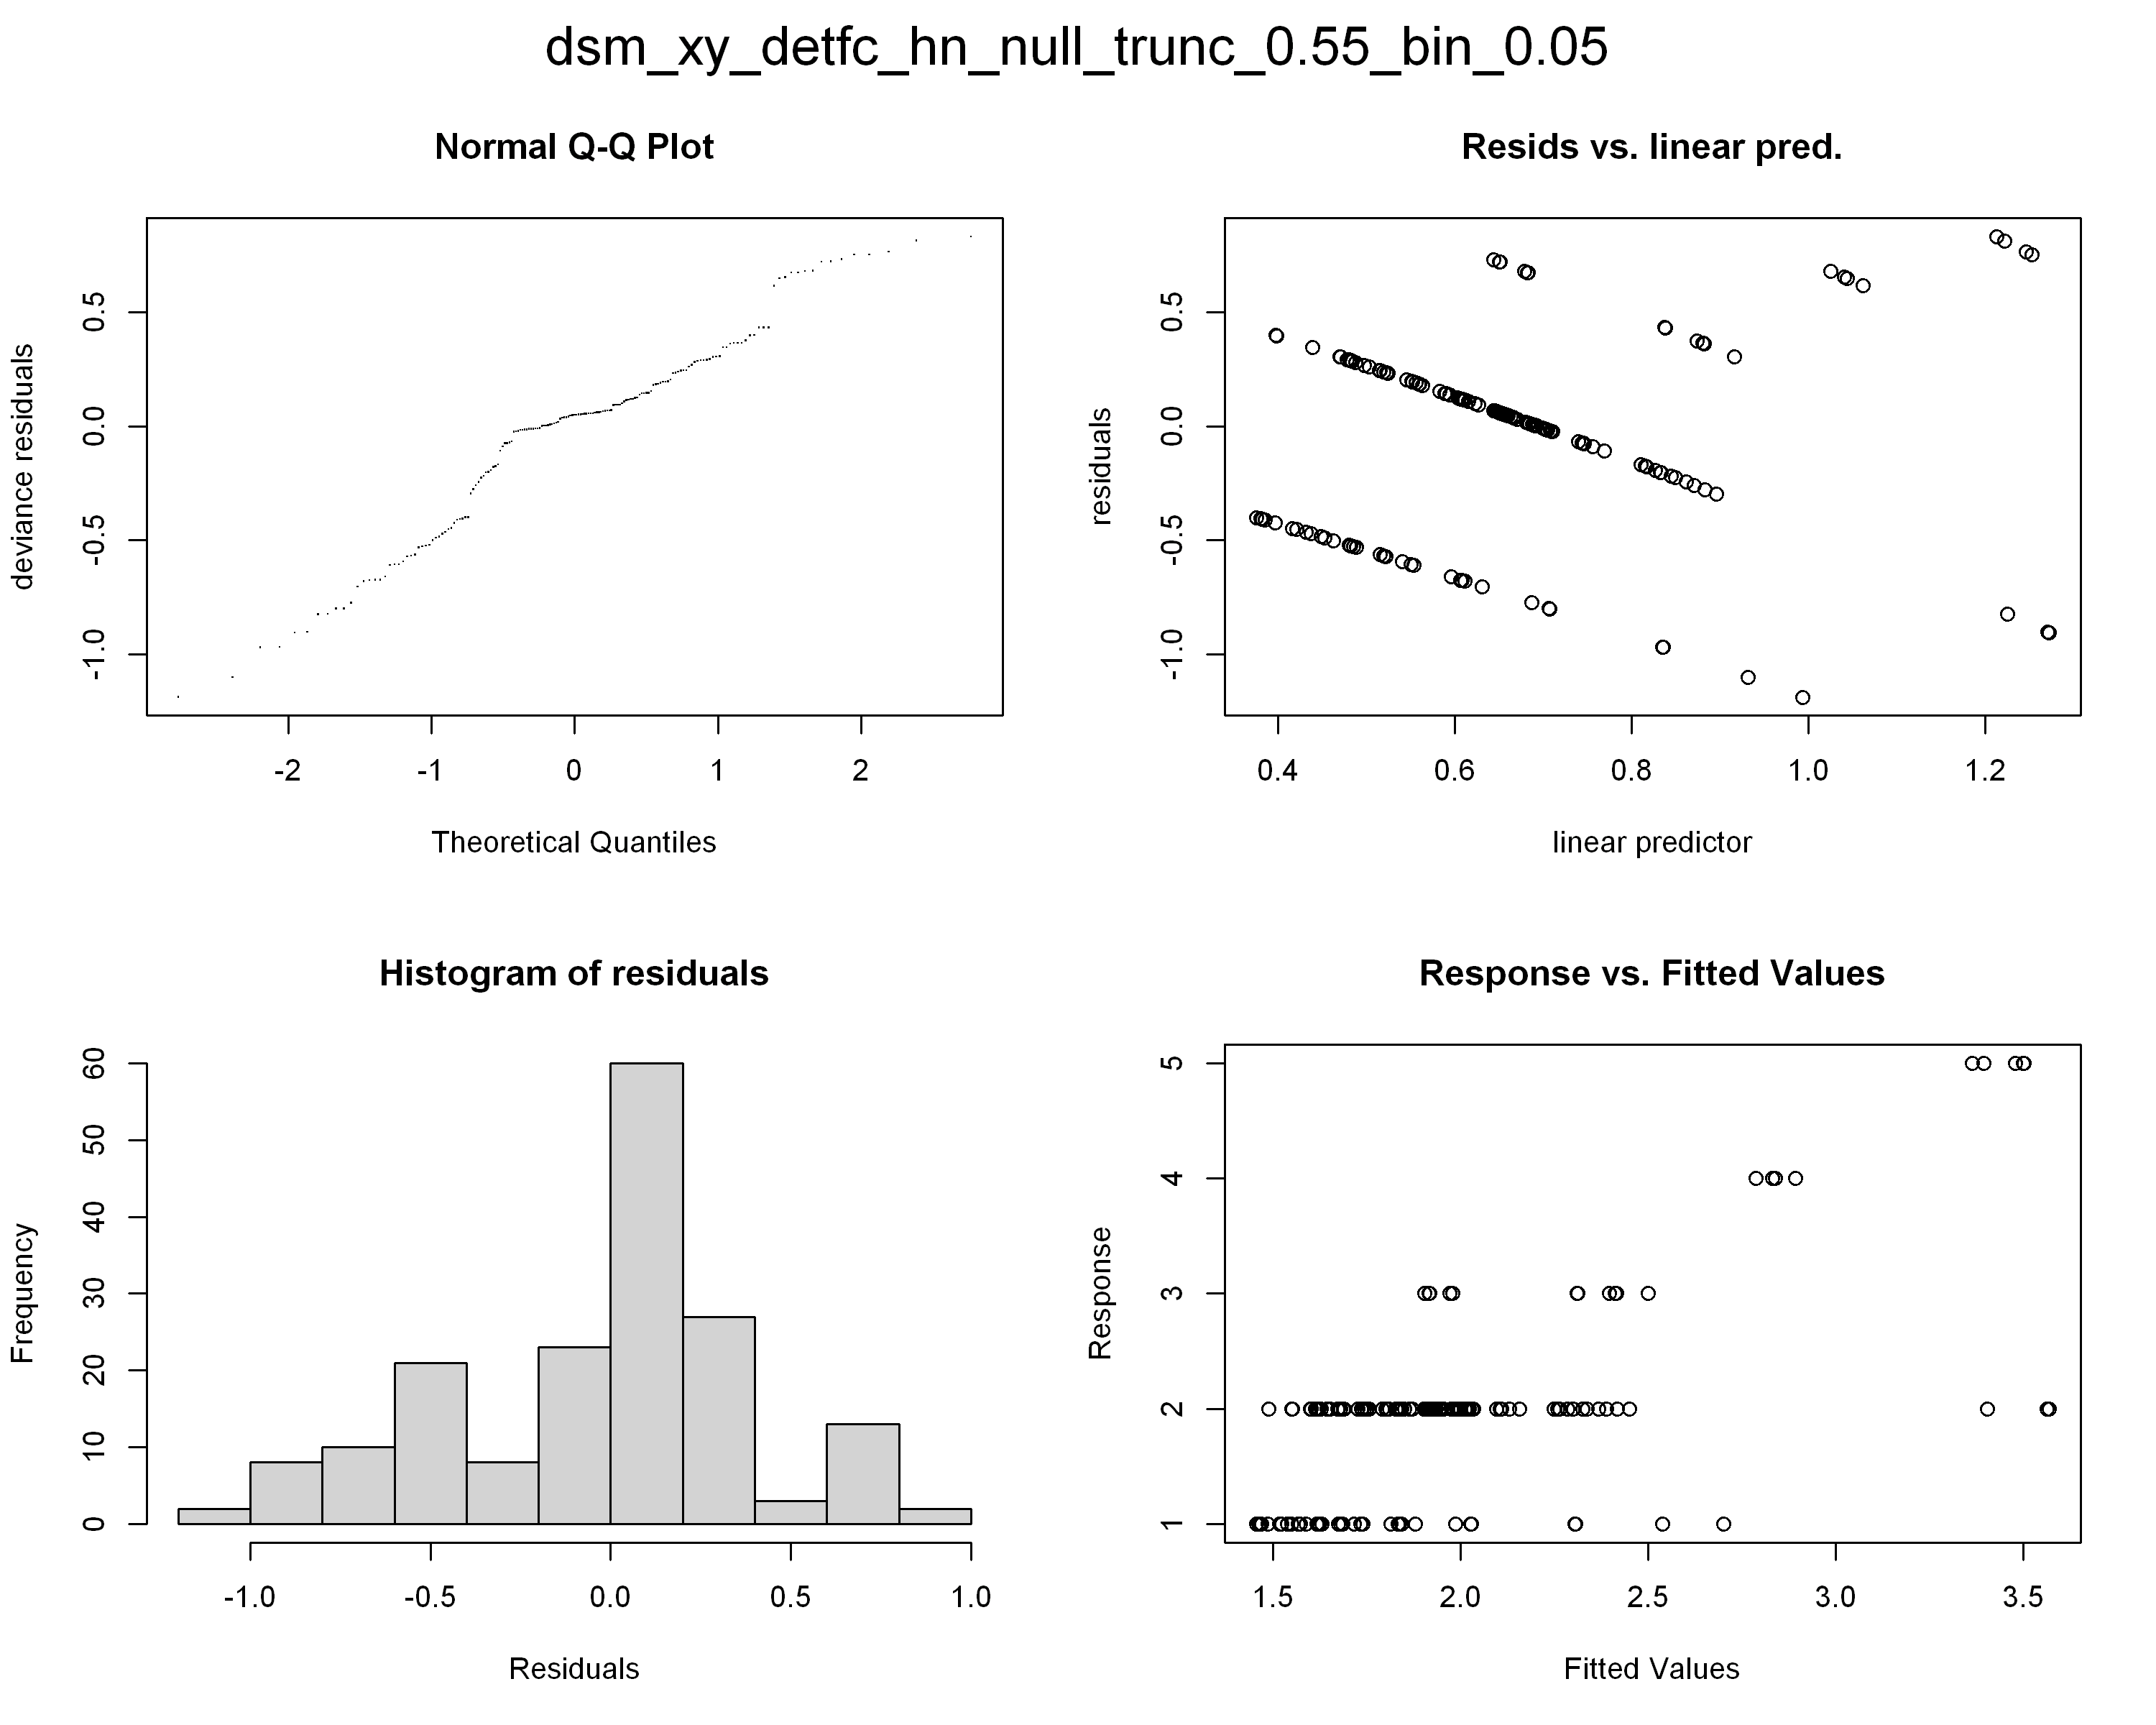

In [11]:

par(mfrow = c(2, 2), oma = c(0, 0, 2, 0))
  model <- dsm_list[[7]]
  gam.check(model)
  # Add a title to the entire plotting area
  print(model$name)
  mtext(model$name, outer = TRUE, cex = 1.5)

par(mfrow = c(1, 1))




Summarise model results

In [12]:

mod_results <- data.frame(
  "Deviance explained" = sapply(
    dsm_list,
    function(x) paste0(round(summary(x)$dev.expl * 100, 2), "%")
  )
)

knitr::kable(mod_results, col.names = c("Model name", "Deviance explained"))




|Model name                                      |Deviance explained |
|:-----------------------------------------------|:------------------|
|dsm_xy_detfc_hr_null_trunc_0.6_bin_0.05         |40.79%             |
|dsm_xy_detfc_hn_null_trunc_0.6_bin_0.05         |40.79%             |
|dsm_xy_detfc_hn_cos_trunc_0.6_bin_0.05          |40.79%             |
|dsm_est_xy_detfc_cc_hr_null_trunc_0.6_bin_0.05  |51.66%             |
|dsm_est_xy_detfc_cc_hn_null_trunc_0.6_bin_0.05  |42.29%             |
|dsm_xy_detfc_hr_null_trunc_0.55_bin_0.05        |40.79%             |
|dsm_xy_detfc_hn_null_trunc_0.55_bin_0.05        |40.79%             |
|dsm_xy_detfc_hn_cos_trunc_0.55_bin_0.05         |40.79%             |
|dsm_est_xy_detfc_cc_hr_null_trunc_0.55_bin_0.05 |53.37%             |
|dsm_est_xy_detfc_cc_hn_null_trunc_0.55_bin_0.05 |46.77%             |